# About

- Use [Langchain](https://python.langchain.com/en/latest/index.html) to build a chatbot that can answer questions about [Harry Potter books](https://www.kaggle.com/datasets/hinepo/harry-potter-books-in-pdf-1-7)
- Experiment with various LLMs (Large Language Models)
- Use [FAISS vector store](https://python.langchain.com/docs/integrations/vectorstores/faiss) to store text embeddings with [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from [Hugging Face](https://huggingface.co/hkunlp/instructor-large). FAISS runs on GPU and it is much faster than Chroma
- Use [Retrieval chain](https://python.langchain.com/docs/modules/data_connection/retrievers/) to retrieve relevant passages from embedded text
- Summarize retrieved passages
- Use Kaggle dual GPU (2 * T4) with [Hugging Face Accelerate](https://huggingface.co/docs/accelerate/index)
- Chat UI with [Gradio](https://www.gradio.app/guides/quickstart)

No need to create any API key to use this notebook! Everything is open source.

Upvote the notebook if you learn from it or use it! :)

This will help me keep experimenting with new models as soon as they are released

### Models

- [WizardLM](https://huggingface.co/TheBloke/wizardLM-7B-HF)
- [Falcon](https://huggingface.co/h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2)
- [Llama 2-7b](https://huggingface.co/daryl149/llama-2-7b-chat-hf)
- [Llama 2-13b](https://huggingface.co/daryl149/llama-2-13b-chat-hf)
- [Bloom](https://huggingface.co/bigscience/bloom-7b1)

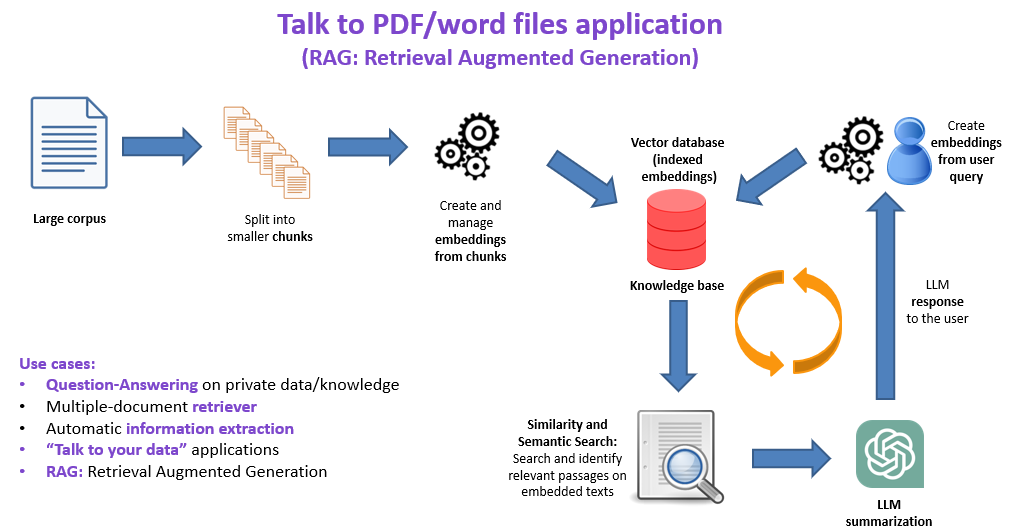

img source: HinePo

In [1]:
! nvidia-smi -L

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU (UUID: GPU-294a8dde-5b6f-e715-7407-de61b791994b)


In [2]:
import os
language = "es"
if os.path.isfile(f"data/vectorstore_{language}/index.faiss"):
    print('available')
else:
    print('not available')

available


# Installs

# Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import textwrap
import time

import langchain

from tqdm import tqdm as tqdm

# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, LLMChain

# vector stores
from langchain.vectorstores import FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
offload_folder = './offload_folder/'

print(langchain.__version__)

In [ ]:
glob.glob('./Data/HP Books/*')

# CFG

- CFG class enables easy and organized experimentation 

In [ ]:
class CFG:
    # LLMs
    model_name = 'bloom' # wizardlm, bloom, falcon, llama2-7b, llama2-13b, 'Photolens-llama-2-7b', 'mdeberta-v3'
    temperature = 0,
    top_p = 0.95,
    repetition_penalty = 1.15    

    # splitting
    split_chunk_size = 1000
    split_overlap = 0
    
    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'    

    # similar passages
    k = 3
    
    # quantization config
    quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)
    
    # paths
    PDFs_path = './Data/HP books/'
    Embeddings_path =  './faiss-hp-sentence-transformers/'
    Persist_directory = './harry-potter-vectordb/'  
    offload_folder = './offload_folder/'

# Define model

In [ ]:
def get_model(model = CFG.model_name):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'wizardlm':
        model_repo = 'TheBloke/wizardLM-7B-HF'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        
        max_len = 1024
        
    elif model == 'Photolens-llama-2-7b':
        model_repo = 'Photolens/llama-2-7b-langchain-chat'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)
        
        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
        )
        
        max_len = 4096
        
    elif model == 'llama2-7b':
        model_repo = 'daryl149/llama-2-7b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
        )
        
        max_len = 2048

    elif model == 'llama2-13b':
        model_repo = 'daryl149/llama-2-13b-chat-hf'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo, use_fast=True)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            offload_folder=offload_folder,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True,
            quantization_config = BitsAndBytesConfig(llm_int8_enable_fp32_cpu_offload=True)
        )
        
        max_len = 8192

    elif model == 'bloom':
        model_repo = 'bigscience/bloom-7b1'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
        )
        
        max_len = 1024

    elif model == 'falcon':
        model_repo = 'h2oai/h2ogpt-gm-oasst1-en-2048-falcon-7b-v2'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
        )
        
        max_len = 1024
    
    elif model == 'mdeberta-v3':
        model_repo = 'timpal0l/mdeberta-v3-base-squad2'
        
        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            device_map='auto',
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
        )
        
        max_len = 2048

    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len

In [ ]:
%%time

tokenizer, model, max_len = get_model(model = CFG.model_name)

In [ ]:
### check how Accelerate split the model across the available devices (GPUs)
model.hf_device_map

# 🤗 pipeline

- Hugging Face pipeline

In [ ]:
pipe = pipeline(
    task = "text-generation",
    model = model,
    tokenizer = tokenizer,
    pad_token_id = tokenizer.eos_token_id,
    max_length = max_len,
    temperature = CFG.temperature,
    top_p = CFG.top_p,
    repetition_penalty = CFG.repetition_penalty
)

llm = HuggingFacePipeline(pipeline = pipe)

In [ ]:
llm

In [ ]:
%%time

### testing model, not using the harry potter books yet
### answer is not necessarily related to harry potter
query = "Give me 5 examples of cool potions and explain what they do"
llm(query)

# 🦜🔗 Langchain

- Multiple document retriever with LangChain

In [ ]:
CFG.model_name

## Loader

- [Directory loader](https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory) for multiple files
- This step is not necessary if you are just loading the vector database
- This step is necessary if you are creating embeddings. In this case you need to:
    - load de PDF files
    - split into chunks
    - create embeddings
    - save the embeddings in a vector store
    - After that you can just load the saved embeddings to do similarity search with the user query, and then use the LLM to answer the question

## Splitter

- Splitting the text into chunks so its passages are easily searchable for similarity
- This step is also only necessary if you are creating the embeddings
- [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/reference/modules/document_loaders.html?highlight=RecursiveCharacterTextSplitter#langchain.document_loaders.MWDumpLoader)

## Embeddings

- Embedd and store the texts in a Vector database (FAISS)
- [LangChain Vector Stores docs](https://python.langchain.com/docs/modules/data_connection/vectorstores/)
- [FAISS - langchain](https://python.langchain.com/docs/integrations/vectorstores/faiss)
- [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks - paper Aug/2019](https://arxiv.org/pdf/1908.10084.pdf)
- [This is a nice 4 minutes video about vector stores](https://www.youtube.com/watch?v=dN0lsF2cvm4)
- [Chroma - Persist and load the vector database](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/chroma.html)

## Create vector database

- If you use Chroma vector store it will take ~35 min to create embeddings
- If you use FAISS vector store on GPU it will take just ~3 min


We need to create the embeddings only once, and then we can just load the vector store and query the database using similarity search. 

Loading the embeddings takes only a few seconds.

I uploaded the embeddings to a Kaggle Dataset so we just load it from [here](https://www.kaggle.com/datasets/hinepo/faiss-hp-sentence-transformers).

## Load vector database

- After saving the vector database, we just load it from the Kaggle Dataset I mentioned
- Obviously, the embeddings function to load the embeddings must be the same as the one used to create the embeddings

In [ ]:
%%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = CFG.embeddings_model_repo,
    model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    CFG.Embeddings_path,
    embeddings
)

In [ ]:
### test if vector DB was loaded correctly
vectordb.similarity_search('magic creatures')

# Prompt Template

- Custom prompt

In [ ]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked. 
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template, 
    input_variables = ["context", "question"]
)

In [ ]:
# llm_chain = LLMChain(prompt=PROMPT, llm=llm)
# llm_chain

# Retriever chain

- Retriever to retrieve relevant passages
- Chain to answer questions
- [RetrievalQA: Chain for question-answering](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [ ]:
retriever = vectordb.as_retriever(search_kwargs = {"k": CFG.k, "search_type" : "similarity"})

qa_chain = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type = "stuff", # map_reduce, map_rerank, stuff, refine
    retriever = retriever, 
    chain_type_kwargs = {"prompt": PROMPT},
    return_source_documents = True,
    verbose = False
)

In [ ]:
### testing MMR search
question = "Which are Hagrid's favorite animals?"
vectordb.max_marginal_relevance_search(question, k = CFG.k)

In [ ]:
### testing similarity search
question = "Which are Hagrid's favorite animals?"
vectordb.similarity_search(question, k = CFG.k)

## Post-process outputs

- Format llm response
- Cite sources (PDFs)
- Change `width` parameter to format the output

In [ ]:
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])
    
    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4] + ' - page: ' + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )
    
    ans = ans + '\n\nSources: \n' + sources_used
    return ans

In [ ]:
def llm_ans(query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str

# Ask questions

- Question Answering from multiple documents
- Run QA Chain
- Talk to your data

In [ ]:
CFG.model_name

In [ ]:
model

In [ ]:
query = "Which are Hagrid's favorite animals?"
print(llm_ans(query))

In [ ]:
query = "Which challenges does Harry face during the Triwizard Tournament?"
print(llm_ans(query))

In [ ]:
query = "Is Malfoy an ally of Voldemort?"
print(llm_ans(query))

In [ ]:
query = "What are horcrux?"
print(llm_ans(query))

In [ ]:
query = "Give me 5 examples of cool potions and explain what they do"
print(llm_ans(query))

In [ ]:
query = "What did Gandalf do in the story?"
print(llm_ans(query))

In [ ]:
query = "Was Gandalf in the Harry Potter books?"
print(llm_ans(query))

In [ ]:
query = "¿Cuál es la profesión de los padres de Harry Potter?"
print(llm_ans(query))

In [ ]:
query = "Dame 5 ejemplos de pociones geniales y explica para qué sirven."
print(llm_ans(query))

# Gradio Chat UI

- Create a chat UI with [Gradio](https://www.gradio.app/guides/quickstart)
- [ChatInterface docs](https://www.gradio.app/docs/chatinterface)
- The notebook should be running if you want to use the chat interface
- Print of the chat UI below

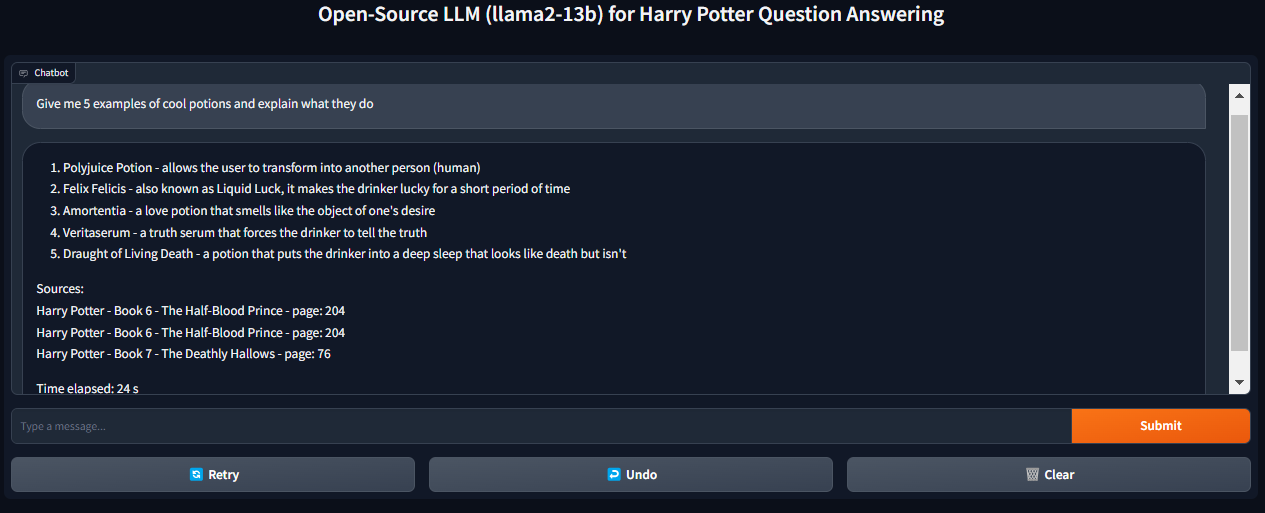

# Conclusions

- Feel free to fork and optimize the code. Lots of things can be improved.

- Things I found had the most impact on models output quality in my experiments:
    - Prompt engineering
    - Bigger models
    - Other models families
    - Splitting: chunk size, overlap
    - Search: Similarity, MMR, k
    - Pipeline parameters (temperature, top_p, penalty)
    - Embeddings function
    - LLM parameters (max len)


- LangChain, Hugging Face and Gradio are awesome libs!

- Upvote if you liked it or want me to keep updating this with new models and functionalities!

🦜🔗🤗

### Conversational Chatbot

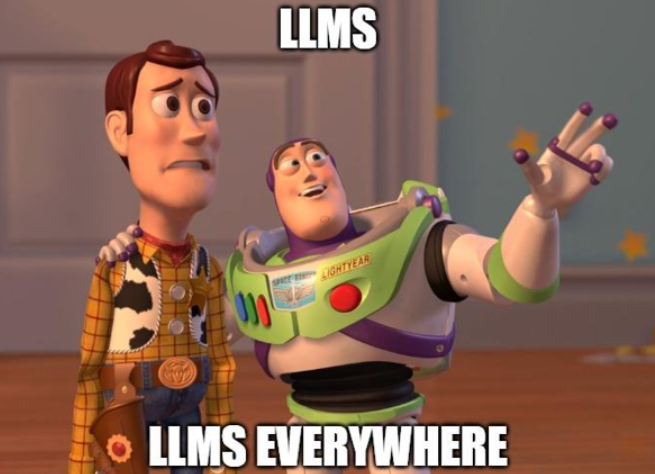